In [1]:
from __future__ import print_function
import os
import numpy as np
import glob
from PIL import Image  
from random import *  
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline
import pandas as pd
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from tensorflow.keras.layers import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D 
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow
import tensorflow.keras
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')

In [2]:
# fix random seed for reproducibility
np.random.seed(10)

In [3]:
#Use the dataset2.csv dataset2
dataframe = pd.read_csv('dataset2/train2.csv', usecols=[2], engine='python', skipfooter=3)
dataset2   = dataframe.values
dataset2   = dataset2.astype('float32')
dataframe.head()

,water level
0,852.0
1,972.0
2,1040.0
3,1280.0
4,1540.0


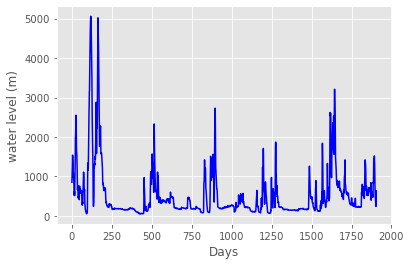

In [4]:
plt.plot(dataset2, color="blue")
plt.xlabel('Days')
plt.ylabel('water level (m)')

plt.show()


In [5]:
# normalize the dataset2
scaler  = MinMaxScaler(feature_range=(0, 1))
dataset2 = scaler.fit_transform(dataset2)


In [6]:
# split into train and test sets
train_size  = int(len(dataset2) * 0.67)
test_size   = len(dataset2) - train_size
train, test = dataset2[0:train_size,:], dataset2[train_size:len(dataset2),:]
print(len(train), len(test))


1277 629


----------------- train data -----------------


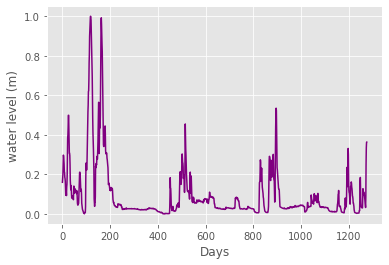

----------------- test data -----------------


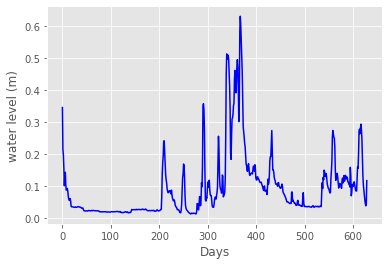

In [7]:
f, ax1 = plt.subplots(figsize=(6, 4))
print('----------------- train data -----------------')
plt.plot(train, color="purple")
plt.xlabel('Days')
plt.ylabel('water level (m)')
plt.show()

plt.show()
f, ax1 = plt.subplots(figsize=(6, 4))
print('----------------- test data -----------------')
plt.plot(test, color="blue")
plt.xlabel('Days')
plt.ylabel('water level (m)')
plt.show()


In [8]:
# This function creates a sliding window of the dataset2.
def create_dataset2(dataset2, sliding_window=1):
    dataX, dataY = [], []
    for i in range(len(dataset2)-sliding_window-1):
        a = dataset2[i:(i+sliding_window), 0]
        dataX.append(a)
        dataY.append(dataset2[i + sliding_window, 0])
    return np.array(dataX), np.array(dataY)


In [9]:
# use a n-10 sliding window equivalent to 2.5 hours of historical data
slide_window   = 10
trainX, trainY = create_dataset2(train, slide_window)
testX, testY   = create_dataset2(test, slide_window)


In [10]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX  = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))



In [11]:
#Setup the LSTM

model = Sequential()
model.add(LSTM(4, input_dim=slide_window))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',)
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2,)


Epoch 1/50
1266/1266 - 4s - loss: 0.0044
Epoch 2/50
1266/1266 - 1s - loss: 0.0022
Epoch 3/50
1266/1266 - 1s - loss: 0.0016
Epoch 4/50
1266/1266 - 1s - loss: 0.0014
Epoch 5/50
1266/1266 - 2s - loss: 0.0012
Epoch 6/50
1266/1266 - 1s - loss: 0.0011
Epoch 7/50
1266/1266 - 1s - loss: 0.0010
Epoch 8/50
1266/1266 - 1s - loss: 9.7482e-04
Epoch 9/50
1266/1266 - 1s - loss: 9.2770e-04
Epoch 10/50
1266/1266 - 1s - loss: 8.8569e-04
Epoch 11/50
1266/1266 - 1s - loss: 8.7549e-04
Epoch 12/50
1266/1266 - 2s - loss: 8.3077e-04
Epoch 13/50
1266/1266 - 2s - loss: 8.1726e-04
Epoch 14/50
1266/1266 - 2s - loss: 8.3153e-04
Epoch 15/50
1266/1266 - 2s - loss: 7.4796e-04
Epoch 16/50
1266/1266 - 2s - loss: 7.6977e-04
Epoch 17/50
1266/1266 - 2s - loss: 7.5384e-04
Epoch 18/50
1266/1266 - 2s - loss: 7.3079e-04
Epoch 19/50
1266/1266 - 2s - loss: 7.2197e-04
Epoch 20/50
1266/1266 - 2s - loss: 6.6951e-04
Epoch 21/50
1266/1266 - 2s - loss: 6.6856e-04
Epoch 22/50
1266/1266 - 2s - loss: 6.9017e-04
Epoch 23/50
1266/1266 - 2

In [12]:
# Print out the evaluation for both the
trainScore = model.evaluate(trainX, trainY, verbose=0)
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(np.array([[trainScore]]))
print('Train Score: %.2f RMSE' % trainScore)
testScore = model.evaluate(testX, testY, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))
print('Test Score: %.2f RMSE' % testScore)




Train Score: 192.28 RMSE
Test Score: 195.95 RMSE


In [13]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


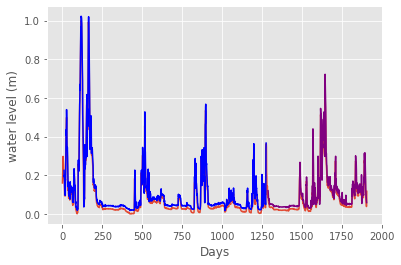

In [14]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[slide_window:len(trainPredict) + slide_window, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (slide_window * 2) + 1:len(dataset2) - 1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset2)
plt.plot(trainPredictPlot, color="blue")
plt.plot(testPredictPlot, color="purple")
plt.xlabel('Days')
plt.ylabel('water level (m)')
plt.show()


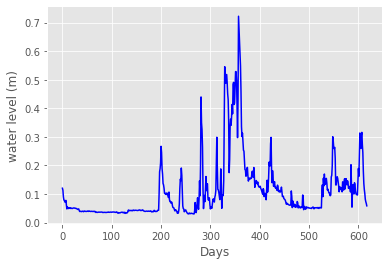

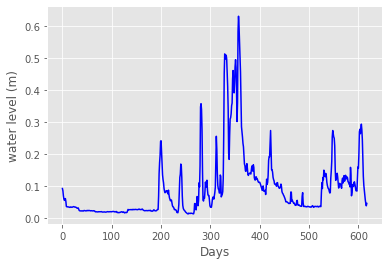

In [15]:
plt.plot(testPredict, color="blue")
plt.xlabel('Days')
plt.ylabel('water level (m)')
plt.show()

plt.plot(testY, color="blue")
plt.xlabel('Days')
plt.ylabel('water level (m)')
plt.show()


In [16]:
# Test the network on an unseen dataset2
unseen = pd.read_csv('dataset2/test2.csv',sep=',')


In [17]:
unseen.head()

,date,time,water level
0,01/01/2010,13.32,615.0
1,02/01/2010,13.35,615.0
2,03/01/2010,13.31,655.0
3,04/01/2010,13.39,420.0
4,05/01/2010,13.32,441.0


In [18]:
unseen_test = unseen['water level'].values



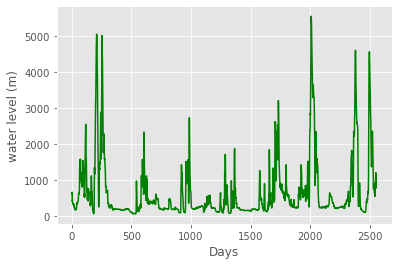

In [20]:
plt.plot(unseen_test[0:20000], color="green")
plt.xlabel('Days')
plt.ylabel('water level (m)')
plt.show()

In [21]:
unseen_clean = []
for i in unseen_test:
    unseen_clean.append([i])
unseen_clean = np.asarray(unseen_clean).astype('float32')
unseen_clean = scaler.fit_transform(unseen_clean)


In [22]:
features,labels = create_dataset2(unseen_clean, slide_window)
features        = np.reshape(features, 25460)



In [23]:
unseen_results = model.predict(testX)

-------------------- Model Prediction --------------------


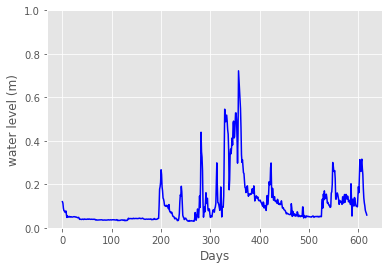

-------------------- Actual Measurement --------------------


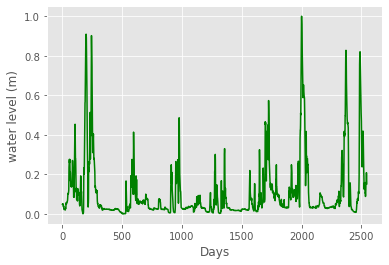

In [24]:
plt.gca().set_ylim(bottom=0)
plt.gca().set_ylim(top=1)

print('-------------------- Model Prediction --------------------')
plt.plot(unseen_results[0:20000], color="blue")
plt.xlabel('Days')
plt.ylabel('water level (m)')
plt.show()


print('-------------------- Actual Measurement --------------------')
plt.plot(labels, color="green")
plt.xlabel('Days')
plt.ylabel('water level (m)')
plt.show()



The value of R-squared of water level is  0.9282043737502735


<function matplotlib.pyplot.show(close=None, block=None)>

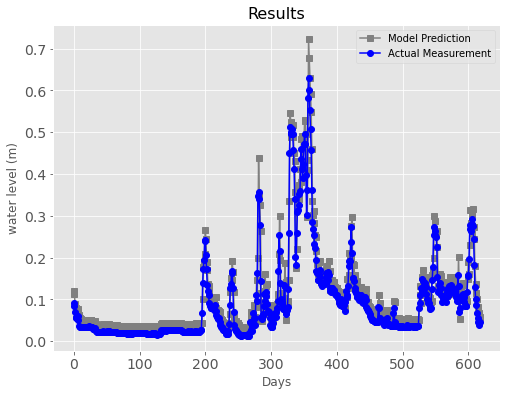

In [26]:

print('The value of R-squared of water level is ', r2_score(unseen_results, testY))

f, ax1 = plt.subplots(figsize=(8, 6))
plt.plot(unseen_results, color="grey", linestyle="-", marker="s", linewidth=1.5, label="Model Prediction")

plt.plot(testY, color="blue", linestyle="-", marker="o", linewidth=1.5, label="Actual Measurement")

ax1.set_title('Results', fontsize=16, fontweight='normal')
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
plt.legend(loc='upper right')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('Days')
plt.ylabel('water level (m)')
plt.show
